<a href="https://colab.research.google.com/github/eyupdalan/BLM6114-project-v2/blob/main/BLM6114_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BLM6114 Hesaplamalı Anlambilim Dersi Dönem Sonu Projesi

## Ortam Kurulumu

In [ ]:
!pip install -q transformers datasets scikit-learn umap-learn matplotlib huggingface-hub sentence-transformers
!pip install -q openai
!pip install -q torch accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.0 MB/s eta 0:00:00


## Huggingface login

In [ ]:
from google.colab import userdata
token = userdata.get('HF_TOKEN')

from huggingface_hub import login
login(token=token)

def hf_login():
  login(token=token)

## Veri seti işlemleri

In [ ]:
from huggingface_hub import hf_hub_download
import pandas as pd

df = pd.read_csv("hf://datasets/ytu-ce-cosmos/gsm8k_tr/gsm8k_tr.csv")
print(df.columns)
df.head()


Index(['question', 'answer'], dtype='object')


,question,answer
0,Borris tekel bayisi her 6 ayda bir 90 kilogram...,Borris şu anda her 6 ayda 90 kilogram üzüm kul...
1,"Mel, Katherine'den üç yaş küçük. Katherine ik...",Katherine iki düzine yaşına geldiğinde 24 yaşı...
2,James 2 ağacındaki tüm meyveleri toplar. Her ...,James 24 ağaç dikmiştir.
3,"Kyle, her biri 15 origami yıldızı alabilen 2 c...",Kyle toplamda 5 cam şişe satın aldı (2 + 3). H...
4,Mark'ın iki evcil hayvanı var: Saniyede 10 adı...,Kaplumbağanın yarışı berabere bitirmesi için 1...


## Soru türü ve cevap yöntemi tespit etme

In [ ]:
import os
import pandas as pd
import openai
import json
from google.colab import userdata

token = userdata.get('OPEN_AI_API_KEY')

# API anahtarını ayarla
client = openai.OpenAI(api_key=token)

def classify_question_and_method(question: str, answer: str) -> str:
    """
    İki cümle döndürür:
    1) Sorunun türü
    2) Çözüm yöntemi
    """

    prompt = (
    f"Soru: {question}\n"
    f"Cevap: {answer}\n\n"
    "Lütfen **yalnızca JSON** formatında cevapla ve şu iki alanı içersin:\n"
    "{\n"
    '  "question_type": "<kısa ve net bir cümle olarak sorunun türü (“toplama”, “oran-orantı” vb.)>",\n'
    '  "solution_method": "<kısa ve net bir cümle olarak çözüm yöntemi (“denklem kurma”, “birim oran” vb.)>"\n'
    "}\n"
    "Cevapta başka metin veya açıklama OLMAMALI."
    )

    resp = client.chat.completions.create(
        model='gpt-4o',
        messages=[{'role':'user','content':prompt}],
        temperature=0
    )
    result = resp.choices[0].message.content.strip()
    json_string = "\n".join(result.strip().splitlines()[1:-1])
    data = json.loads(json_string)
    return data['question_type'], data['solution_method']



### İlk 5 kayıt için deneme

In [ ]:
import pandas as pd

# Veri kümesini yükleme
df = pd.read_csv("hf://datasets/ytu-ce-cosmos/gsm8k_tr/gsm8k_tr.csv")
sample = df.head(5).copy()

# Sample için sınıflandırma
sample["question_type"], sample["solution_method"] = zip(*sample.apply(
    lambda row: classify_question_and_method(row['question'], row['answer']), axis=1
))
sample.head()

### Tüm veriler için soru tipi ve çözüm metodu tespiti ve kaydedilmesi

In [ ]:
df = pd.read_csv("hf://datasets/ytu-ce-cosmos/gsm8k_tr/gsm8k_tr.csv")
df["question_type"], df["solution_method"] = zip(*df.apply(
    lambda row: classify_question_and_method(row['question'], row['answer']), axis=1
))

df.to_csv('gsm8k_tr_classified.csv', index=False)

## Sınıflandırma sonuçları

In [ ]:
df_classified = pd.read_csv("gsm8k_tr_classified.csv")
print("\nKolon Bilgileri:")
print(df_classified.info())

print("\n'question_type' kolonundaki unique değer sayısı:", df_classified['question_type'].nunique())
print("'solution_method' kolonundaki unique değer sayısı:", df_classified['solution_method'].nunique())

print("\n'question_type' dağılımı (En sık görülen 10):")
print(df_classified['question_type'].value_counts().head(10))

print("\n'solution_method' dağılımı (En sık görülen 10):")
print(df_classified['solution_method'].value_counts().head(10))

print("\n'question_type' tüm değer sayıları:")
print(df_classified['question_type'].value_counts())

print("\n'solution_method' tüm değer sayıları:")
print(df_classified['solution_method'].value_counts())

df_classified.head()



Kolon Bilgileri:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8792 entries, 0 to 8791
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   question         8792 non-null   object
 1   answer           8792 non-null   object
 2   question_type    8792 non-null   object
 3   solution_method  8792 non-null   object
dtypes: object(4)
memory usage: 274.9+ KB
None

'question_type' kolonundaki unique değer sayısı: 399
'solution_method' kolonundaki unique değer sayısı: 793

'question_type' dağılımı (En sık görülen 10):
question_type
oran-orantı           3224
toplama               1588
toplama ve çıkarma     435
zaman hesaplama        235
çıkarma                223
yüzde hesaplama        186
denklem kurma          184
çarpma                 168
denklem çözme          160
yaş problemi           134
Name: count, dtype: int64

'solution_method' dağılımı (En sık görülen 10):
solution_method
birim oran               230

,question,answer,question_type,solution_method
0,Borris tekel bayisi her 6 ayda bir 90 kilogram...,Borris şu anda her 6 ayda 90 kilogram üzüm kul...,oran-orantı,yüzde hesaplama
1,"Mel, Katherine'den üç yaş küçük. Katherine ik...",Katherine iki düzine yaşına geldiğinde 24 yaşı...,yaş problemi,doğrudan çıkarma
2,James 2 ağacındaki tüm meyveleri toplar. Her ...,James 24 ağaç dikmiştir.,oran-orantı,birim oran
3,"Kyle, her biri 15 origami yıldızı alabilen 2 c...",Kyle toplamda 5 cam şişe satın aldı (2 + 3). H...,çarpma,doğrudan çarpma
4,Mark'ın iki evcil hayvanı var: Saniyede 10 adı...,Kaplumbağanın yarışı berabere bitirmesi için 1...,oran-orantı,birim oran


Dosya başarıyla yüklendi.


<ipython-input-23-ea186ae2b19f>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_classified, y='question_type', order=df_classified['question_type'].value_counts().index[:10], palette='viridis')


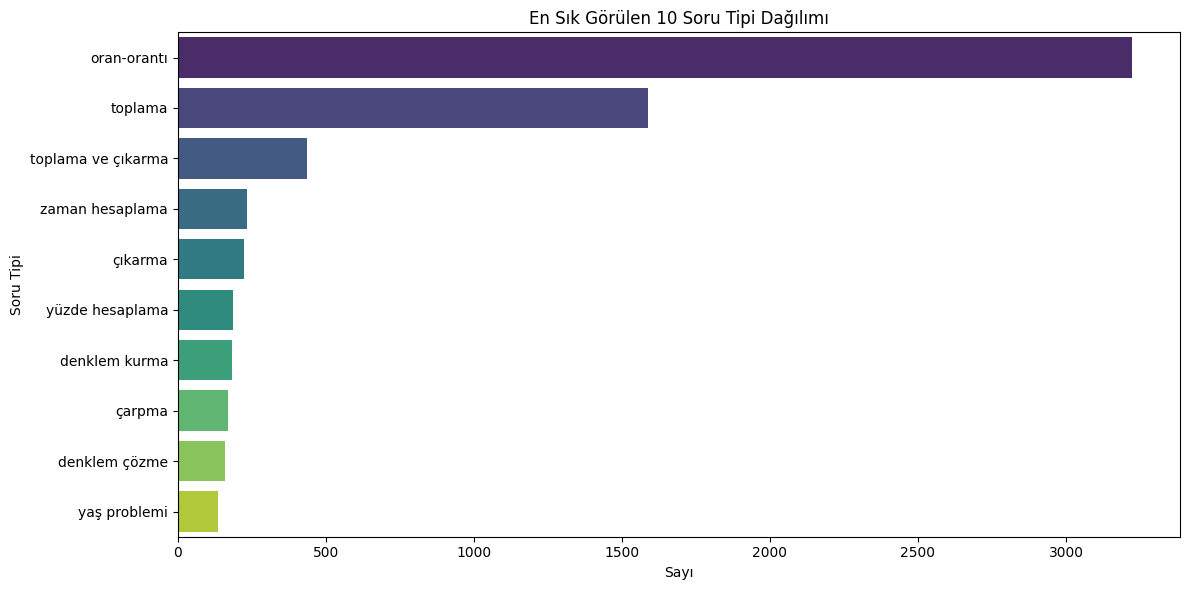

<ipython-input-23-ea186ae2b19f>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_classified, y='solution_method', order=df_classified['solution_method'].value_counts().index[:10], palette='magma')


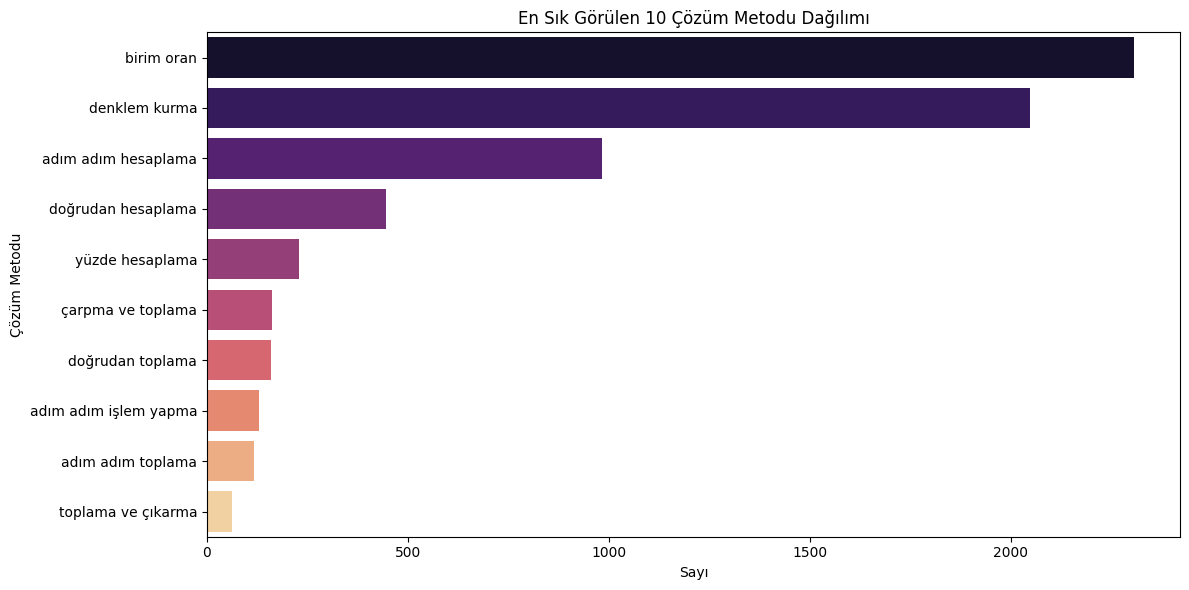

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Veri Kümesini Yükleme
try:
    df_classified = pd.read_csv("gsm8k_tr_classified.csv")
    print("Dosya başarıyla yüklendi.")
except FileNotFoundError:
    print("Hata: 'gsm8k_tr_classified.csv' dosyası bulunamadı.")
    print("Lütfen dosyanın doğru yolda olduğundan emin olun.")
    exit() # Dosya bulunamazsa programı sonlandır

# 'question_type' dağılımını görselleştirme (En sık görülen 10)
plt.figure(figsize=(12, 6))
sns.countplot(data=df_classified, y='question_type', order=df_classified['question_type'].value_counts().index[:10], palette='viridis')
plt.title('En Sık Görülen 10 Soru Tipi Dağılımı')
plt.xlabel('Sayı')
plt.ylabel('Soru Tipi')
plt.tight_layout()
plt.show()

# 'solution_method' dağılımını görselleştirme (En sık görülen 10)
plt.figure(figsize=(12, 6))
sns.countplot(data=df_classified, y='solution_method', order=df_classified['solution_method'].value_counts().index[:10], palette='magma')
plt.title('En Sık Görülen 10 Çözüm Metodu Dağılımı')
plt.xlabel('Sayı')
plt.ylabel('Çözüm Metodu')
plt.tight_layout()
plt.show()

## Embedding İşlemleri

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

df = pd.read_csv("gsm8k_tr_classified.csv")
print("Veri seti okundu:")
print(df.head())

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("ytu-ce-cosmos/turkish-e5-large")
model     = AutoModel.from_pretrained("ytu-ce-cosmos/turkish-e5-large").to(device)

def embed_texts(texts, batch_size=16):
  all_embs = []
  for i in range(0, len(texts), batch_size):
    batch = texts[i : i+batch_size]
    enc = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
      last_hidden = model(**enc).last_hidden_state  # (B, L, D)
      emb = last_hidden.mean(dim=1)                 # mean pooling → (B, D)
    all_embs.append(emb.cpu())
  return torch.cat(all_embs, dim=0).numpy()

for col in ["question", "answer", "question_type", "solution_method"]:
  print(f"Embedding yapılıyor: {col}")
  embs = embed_texts(df[col].astype(str).tolist(), batch_size=16)
  df[f"{col}_emb"] = list(embs) # embedding'i sonuna "_emb" eklenerek yeni kolon olarak ekleniyor.
  print(f"Embedding tamamlandı: {col}")

df.to_pickle("gsm8k_tr_with_embeddings.pkl")


Veri seti okundu:
                                            question  \
0  Borris tekel bayisi her 6 ayda bir 90 kilogram...   
1  Mel, Katherine'den üç yaş küçük.  Katherine ik...   
2  James 2 ağacındaki tüm meyveleri toplar.  Her ...   
3  Kyle, her biri 15 origami yıldızı alabilen 2 c...   
4  Mark'ın iki evcil hayvanı var: Saniyede 10 adı...   

                                              answer question_type  \
0  Borris şu anda her 6 ayda 90 kilogram üzüm kul...   oran-orantı   
1  Katherine iki düzine yaşına geldiğinde 24 yaşı...  yaş problemi   
2                           James 24 ağaç dikmiştir.   oran-orantı   
3  Kyle toplamda 5 cam şişe satın aldı (2 + 3). H...        çarpma   
4  Kaplumbağanın yarışı berabere bitirmesi için 1...   oran-orantı   

    solution_method  
0   yüzde hesaplama  
1  doğrudan çıkarma  
2        birim oran  
3   doğrudan çarpma  
4        birim oran  


tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Embedding yapılıyor: question
Embedding tamamlandı: question
Embedding yapılıyor: answer
Embedding tamamlandı: answer
Embedding yapılıyor: question_type
Embedding tamamlandı: question_type
Embedding yapılıyor: solution_method
Embedding tamamlandı: solution_method


In [ ]:
import pandas as pd

try:
    df_embeddings = pd.read_pickle("gsm8k_tr_with_embeddings.pkl")
    print("Embedding dosyası başarıyla yüklendi.")
    print("\nEmbedding içeren veri çerçevesinin ilk 5 satırı:")
    display(df_embeddings.head())
except FileNotFoundError:
    print("Hata: 'gsm8k_tr_with_embeddings.pkl' dosyası bulunamadı.")
    print("Lütfen dosyanın doğru yolda olduğundan emin olun.")

Embedding dosyası başarıyla yüklendi.

Embedding içeren veri çerçevesinin ilk 5 satırı:


,question,answer,question_type,solution_method,question_emb,answer_emb,question_type_emb,solution_method_emb
0,Borris tekel bayisi her 6 ayda bir 90 kilogram...,Borris şu anda her 6 ayda 90 kilogram üzüm kul...,oran-orantı,yüzde hesaplama,"[0.6715006, 1.0025988, -0.8141864, -0.15699771...","[0.5446431, 1.1449226, -0.8158145, 0.37072867,...","[0.62999976, 0.52959335, -0.17818436, -0.99701...","[0.9302153, 0.61091536, 0.08425554, -0.4434367..."
1,"Mel, Katherine'den üç yaş küçük. Katherine ik...",Katherine iki düzine yaşına geldiğinde 24 yaşı...,yaş problemi,doğrudan çıkarma,"[0.52484596, -0.20660642, -0.56891537, -0.7240...","[0.8434993, 0.19339159, -0.5099972, -0.523887,...","[0.66618395, 0.28364077, 0.20713694, -0.786440...","[1.1666344, 0.6607188, 0.56184703, 0.12593304,..."
2,James 2 ağacındaki tüm meyveleri toplar. Her ...,James 24 ağaç dikmiştir.,oran-orantı,birim oran,"[0.10532897, -0.35827264, -1.2728502, -0.37101...","[0.27943563, 0.28232127, -0.38983282, -0.13706...","[0.62999976, 0.52959335, -0.17818436, -0.99701...","[0.82841676, 0.6284556, -0.41272157, -1.368237..."
3,"Kyle, her biri 15 origami yıldızı alabilen 2 c...",Kyle toplamda 5 cam şişe satın aldı (2 + 3). H...,çarpma,doğrudan çarpma,"[-0.57047623, 0.49581084, -0.5631299, -0.70389...","[-0.59139633, 0.22431299, -0.14734289, -0.2561...","[1.5469688, 1.2697403, 1.0542939, -1.1462126, ...","[1.311402, 1.3144699, 0.88381547, -0.9602007, ..."
4,Mark'ın iki evcil hayvanı var: Saniyede 10 adı...,Kaplumbağanın yarışı berabere bitirmesi için 1...,oran-orantı,birim oran,"[0.30706674, 0.041912753, -1.2288647, -0.58014...","[-0.03708125, 0.080958925, 0.4905705, -0.78892...","[0.62999976, 0.52959335, -0.17818436, -0.99701...","[0.82841676, 0.6284556, -0.41272157, -1.368237..."
